---
## Step 0: Load the Dataset

In [58]:
import numpy as np
import pickle


X_train_dict = {'0':0, '1':0, '2':0, '3':0, '4':0, '5':0}
y_train_dict = {'0':0, '1':0, '2':0, '3':0, '4':0, '5':0}
image_shape = (224, 224, 3)
X_train = np.zeros(np.append(0, image_shape))
y_train = np.array([])
    
print("Loading...")
for layer in range(0, 6):
    # Load pickled data
    with open('./dataset/X_train-'+str(layer)+'.p', mode='rb') as f:
        images_dataset = pickle.load(f)
    with open('./dataset/y_train-'+str(layer)+'.p', mode='rb') as f:
        labels_dataset = pickle.load(f)

    X_train_dict[str(layer)] = images_dataset
    y_train_dict[str(layer)] = labels_dataset
    X_train = np.append(X_train, images_dataset, axis=0)
    y_train = np.append(y_train, labels_dataset)

image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

for layer in range(0, n_classes):
    print("shape of X_train_dict[{}] is {}".format(str(layer), X_train_dict[str(layer)].shape))
    print("shape of y_train_dict[{}] is {}".format(str(layer), y_train_dict[str(layer)].shape))
    
assert(len(X_train) == len(y_train))
print("shape of X_train", X_train.shape)
print("shape of y_train", y_train.shape)

Loading...
Image data shape = (224, 224, 3)
Number of classes = 6
shape of X_train_dict[0] is (319, 224, 224, 3)
shape of y_train_dict[0] is (319,)
shape of X_train_dict[1] is (1245, 224, 224, 3)
shape of y_train_dict[1] is (1245,)
shape of X_train_dict[2] is (1024, 224, 224, 3)
shape of y_train_dict[2] is (1024,)
shape of X_train_dict[3] is (879, 224, 224, 3)
shape of y_train_dict[3] is (879,)
shape of X_train_dict[4] is (474, 224, 224, 3)
shape of y_train_dict[4] is (474,)
shape of X_train_dict[5] is (238, 224, 224, 3)
shape of y_train_dict[5] is (238,)
shape of X_train (4179, 224, 224, 3)
shape of y_train (4179,)


---

## Step 1: Dataset Distribution

label 0: Reality
label 4: Limbo which Fischer fell (Mal's house)
label 5: Limbo which Saito fell (Japanese castle)


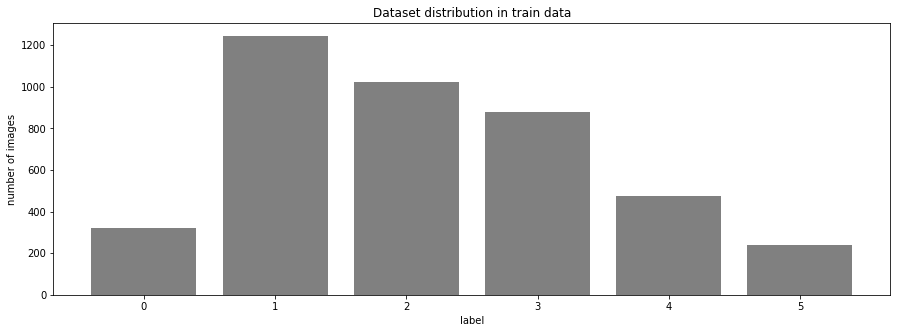

In [59]:
import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline


print("label 0: Reality")
print("label 4: Limbo which Fischer fell (Mal's house)")
print("label 5: Limbo which Saito fell (Japanese castle)")

# Train dataset
n_labels = np.zeros(n_classes)
for i in range(n_classes):
    for j in range(len(X_train)):
        if (y_train[j] == i):
            n_labels[i] += 1

plt.subplots(figsize=(15,5))
plt.xlabel('label')
plt.ylabel('number of images')
plt.title('Dataset distribution in train data')
y_pos = np.arange(n_classes)
barlist = plt.bar(y_pos, n_labels, align='center', color='gray')
plt.xticks(y_pos, np.arange(n_classes))
plt.show()

----

## Step 2: Preprocess the Dataset


In [60]:
import cv2


#Rotate the train data
def Rotate(X_train, degree):
    print("Rotating...")
    rows, cols = X_train.shape[1], X_train.shape[2]
    rotated_X_train = {
        'ccw':np.copy(X_train), 'cw':np.copy(X_train)
    }
    rotated_M = {
        'ccw':cv2.getRotationMatrix2D((cols/2,rows/2), degree, 1), 'cw':cv2.getRotationMatrix2D((cols/2,rows/2), -degree, 1)
    }
    
    for direction in ['ccw', 'cw']:
        for i in range(len(X_train)):
            rotated_X_train[direction][i] = cv2.warpAffine(X_train[i], rotated_M[direction], (cols,rows))
    
    print("The train data has been rotated\n")
    return np.append(rotated_X_train['ccw'], rotated_X_train['cw'], axis=0)

        
#Translate the train data
def Translate(X_train, pixels):
    print("Translating...")
    rows, cols = X_train.shape[1], X_train.shape[2]
    translated_X_train = {
        'top':np.copy(X_train), 'bottom':np.copy(X_train)
    }
    translated_M = {
        'top':np.float32([[1,0,0], [0,1,-pixels]]), 'bottom':np.float32([[1,0,0], [0,1,pixels]])
    }
    
    for direction in ['top', 'bottom']:
        for i in range(len(X_train)):
            translated_X_train[direction][i] = cv2.warpAffine(X_train[i], translated_M[direction], (cols,rows))
            
    print("The train data has been translated\n")
    return np.append(translated_X_train['top'], translated_X_train['bottom'], axis=0)


# Augment the train data
for layer in range(0, n_classes):
    print("\n Layer is ", layer)
    original_n_train = len(X_train_dict[str(layer)])

    if (layer == 0 or layer == 5):
        rotated_X_train = Rotate(X_train_dict[str(layer)], 15)
        translated_X_train = Translate(X_train_dict[str(layer)], 57)
        
        augmented_y_train = np.repeat(y_train_dict[str(layer)], 2)
        assert(len(rotated_X_train) == len(augmented_y_train))
        X_train_dict[str(layer)] = np.append(X_train_dict[str(layer)], rotated_X_train, axis=0)
        y_train_dict[str(layer)] = np.append(y_train_dict[str(layer)], augmented_y_train)
        X_train = np.append(X_train, rotated_X_train, axis=0)
        y_train = np.append(y_train, augmented_y_train, axis=0)
        assert(len(translated_X_train) == len(augmented_y_train))
        X_train_dict[str(layer)] = np.append(X_train_dict[str(layer)], translated_X_train, axis=0)
        y_train_dict[str(layer)] = np.append(y_train_dict[str(layer)], augmented_y_train)
        X_train = np.append(X_train, translated_X_train, axis=0)
        y_train = np.append(y_train, augmented_y_train, axis=0)
    
    if (layer == 4):
        rotated_X_train = Rotate(X_train_dict[str(layer)], 15)
        
        augmented_y_train = np.repeat(y_train_dict[str(layer)], 2)
        assert(len(rotated_X_train) == len(augmented_y_train))
        X_train_dict[str(layer)] = np.append(X_train_dict[str(layer)], rotated_X_train, axis=0)
        y_train_dict[str(layer)] = np.append(y_train_dict[str(layer)], augmented_y_train)
        X_train = np.append(X_train, rotated_X_train, axis=0)
        y_train = np.append(y_train, augmented_y_train, axis=0)
        
    print("The shape of X_train_dict[{}] is {}".format(str(layer), X_train_dict[str(layer)].shape))
    print("The shape of y_train_dict[{}] is {}".format(str(layer), y_train_dict[str(layer)].shape))
    print("The train images has been augmented by a factor of {:.1f}".format(len(X_train_dict[str(layer)])/original_n_train))
    print("The train labels has been augmented by a factor of {:.1f}".format(len(y_train_dict[str(layer)])/original_n_train))

assert(len(X_train) == len(y_train))
print("\n done")
print("shape of X_train", X_train.shape)
print("shape of y_train", y_train.shape)


 Layer is  0
Rotating...
The train data has been rotated

Translating...
The train data has been translated

The shape of X_train_dict[0] is (1595, 224, 224, 3)
The shape of y_train_dict[0] is (1595,)
The train images has been augmented by a factor of 5.0
The train labels has been augmented by a factor of 5.0

 Layer is  1
The shape of X_train_dict[1] is (1245, 224, 224, 3)
The shape of y_train_dict[1] is (1245,)
The train images has been augmented by a factor of 1.0
The train labels has been augmented by a factor of 1.0

 Layer is  2
The shape of X_train_dict[2] is (1024, 224, 224, 3)
The shape of y_train_dict[2] is (1024,)
The train images has been augmented by a factor of 1.0
The train labels has been augmented by a factor of 1.0

 Layer is  3
The shape of X_train_dict[3] is (879, 224, 224, 3)
The shape of y_train_dict[3] is (879,)
The train images has been augmented by a factor of 1.0
The train labels has been augmented by a factor of 1.0

 Layer is  4
Rotating...
The train data h

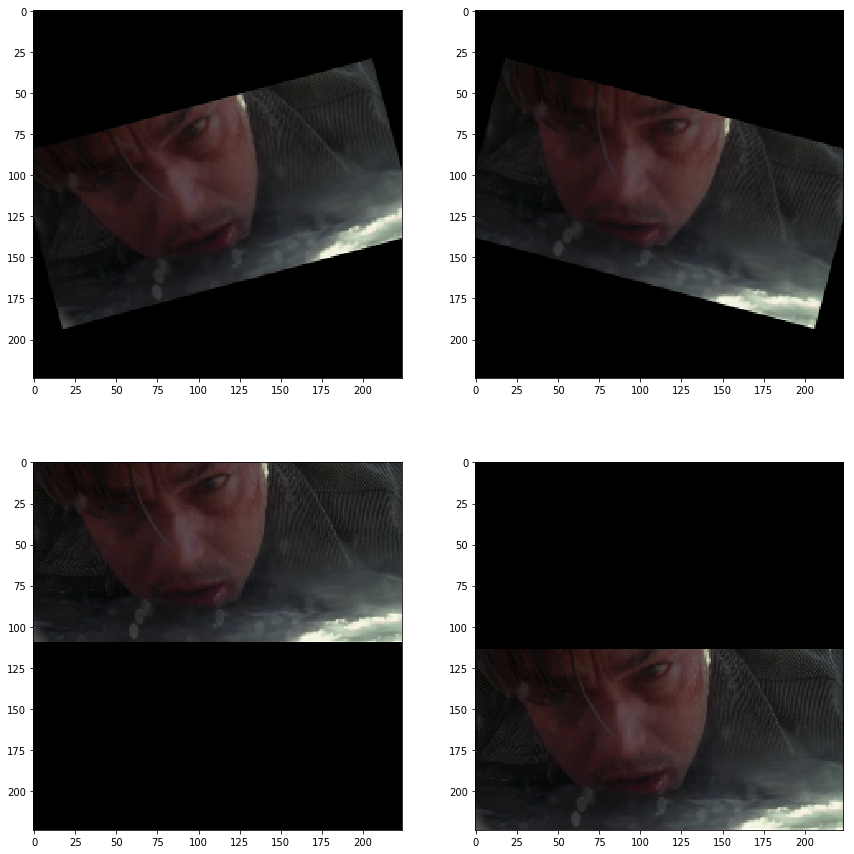

In [61]:
import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline


layer = 5
fig, axes = plt.subplots(nrows=2, ncols=2)
k = 1
for i in range(0, 2):
    for j in range(0, 2):
        axes[i, j].imshow(X_train_dict[str(layer)][33 + 238*k])
        k += 1
fig.subplots_adjust(right=2, top=3)

label 0: Reality
label 4: Limbo which Fischer fell (Mal's house)
label 5: Limbo which Saito fell (Japanese castle)


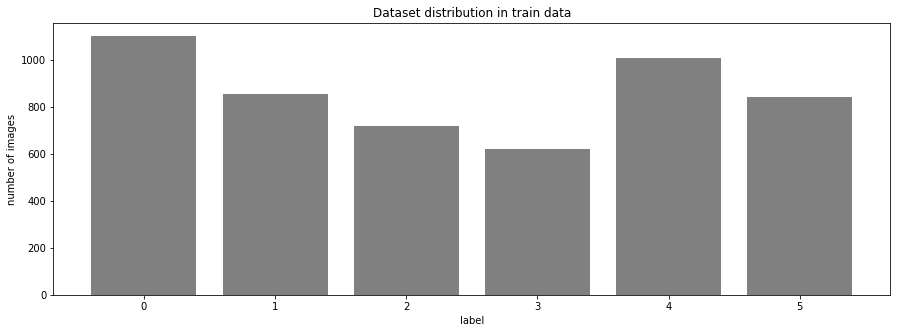

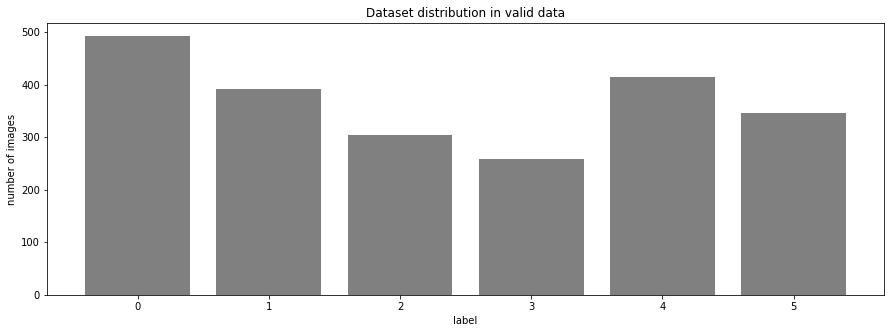

shape of train data is  (5148, 224, 224, 3)
shape of valid data is  (2207, 224, 224, 3)
Saving...
The train data has been saved



In [62]:
from sklearn.model_selection import train_test_split


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42) 

print("label 0: Reality")
print("label 4: Limbo which Fischer fell (Mal's house)")
print("label 5: Limbo which Saito fell (Japanese castle)")

# Train dataset
n_labels = np.zeros(n_classes)
for i in range(n_classes):
    for j in range(len(X_train)):
        if (y_train[j] == i):
            n_labels[i] += 1

plt.subplots(figsize=(15,5))
plt.xlabel('label')
plt.ylabel('number of images')
plt.title('Dataset distribution in train data')
y_pos = np.arange(n_classes)
barlist = plt.bar(y_pos, n_labels, align='center', color='gray')
plt.xticks(y_pos, np.arange(n_classes))
plt.show()

# Valid dataset
n_labels = np.zeros(n_classes)
for i in range(n_classes):
    for j in range(len(X_valid)):
        if (y_valid[j] == i):
            n_labels[i] += 1
            
plt.subplots(figsize=(15,5))
plt.xlabel('label')
plt.ylabel('number of images')
plt.title('Dataset distribution in valid data')
y_pos = np.arange(n_classes)
barlist = plt.bar(y_pos, n_labels, align='center', color='gray')
plt.xticks(y_pos, np.arange(n_classes))
plt.show()

print("shape of train data is ", X_train.shape)
print("shape of valid data is ", X_valid.shape)

#Save the augmented train data
print("Saving...")
with open('./dataset/augmented_X_train.p', mode='wb') as f:
    pickle.dump(X_train, f, protocol=4)
with open('./dataset/augmented_y_train.p', mode='wb') as f:
    pickle.dump(y_train, f, protocol=4)
with open('./dataset/augmented_X_valid.p', mode='wb') as f:
    pickle.dump(X_valid, f, protocol=4)
with open('./dataset/augmented_y_valid.p', mode='wb') as f:
    pickle.dump(y_valid, f, protocol=4)
print("The train data has been saved\n")

### Load the augmented train data using pickle

In [41]:
import pickle

''' Load the augmented train data '''
print("Loading...")
with open('./dataset/augmented_X_train.p', mode='rb') as f:
    X_train = pickle.load(f)
with open('./dataset/augmented_y_train.p', mode='rb') as f:
    y_train = pickle.load(f)
with open('./dataset/augmented_X_valid.p', mode='rb') as f:
    X_valid = pickle.load(f)
with open('./dataset/augmented_y_valid.p', mode='rb') as f:
    y_valid = pickle.load(f)
print("The train data has been loaded")

print("shape of train data is ", X_train.shape)
print("shape of valid data is ", X_valid.shape)

Loading...
The train data has been loaded
shape of train data is  (5148, 224, 224, 3)
shape of valid data is  (2207, 224, 224, 3)


### Grayscale and Normalize the train data

In [42]:
import numpy as np
import cv2


# Grayscale the train data
print("Grayscaling...")
for i in range(len(X_train)):
    X_train[i] = np.expand_dims(cv2.cvtColor(X_train[i].astype(np.float32), cv2.COLOR_RGB2GRAY), axis=2)
    y_train[i] = int(y_train[i])
# Nx32x32x3 ---> Nx32x32x1
X_train = X_train[:, :, :, 0:1]
print("The train data has been grayscaled\n")

# Normarize the train data
print("Normarizing...")
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
print("The train data has been normarized\n")

# Confirm the shape
print("shape of train data is ", X_train.shape)

# Update the shape of a single image
image_shape = X_train[0].shape
print("Image data shape =", image_shape)

Grayscaling...
The train data has been grayscaled

Normarizing...
The train data has been normarized

shape of train data is  (5148, 224, 224, 1)
Image data shape = (224, 224, 1)


### Grayscale and Normalize the valid data also

In [43]:
import numpy as np
import cv2


# Grayscale the train data
print("Grayscaling...")
for i in range(len(X_valid)):
    X_valid[i] = np.expand_dims(cv2.cvtColor(X_valid[i].astype(np.float32), cv2.COLOR_RGB2GRAY), axis=2)
    y_valid[i] = int(y_valid[i])
# Nx32x32x3 ---> Nx32x32x1
X_valid = X_valid[:, :, :, 0:1]
print("The train data has been grayscaled\n")

# Normarize the train data
print("Normarizing...")
X_valid = (X_valid - np.mean(X_valid)) / np.std(X_valid)
print("The train data has been normarized\n")

# Confirm the shape
print("shape of valid data is ", X_valid.shape)

# Update the number of classes
n_classes = len(np.unique(y_train))

Grayscaling...
The train data has been grayscaled

Normarizing...
The train data has been normarized

shape of valid data is  (2207, 224, 224, 1)


----

## Step 3: Design and Test a Model Architecture


### Model Architecture

In [44]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten


def Inception(input_layer, W, b, icp):
    icp_1x1 = tf.nn.bias_add(tf.nn.conv2d(input_layer, W[icp+'_1x1'], strides=[1,1,1,1], padding='SAME'), b[icp+'_1x1'])
    icp_1x1 = tf.nn.relu(icp_1x1)
    
    icp_3x3_reduce = tf.nn.bias_add(tf.nn.conv2d(input_layer, W[icp+'_3x3_reduce'], strides=[1,1,1,1], padding='SAME'), b[icp+'_3x3_reduce'])
    icp_3x3_reduce = tf.nn.relu(icp_3x3_reduce)
    icp_3x3 = tf.nn.bias_add(tf.nn.conv2d(icp_3x3_reduce, W[icp+'_3x3'], strides=[1,1,1,1], padding='SAME'), b[icp+'_3x3'])
    icp_3x3 = tf.nn.relu(icp_3x3)
    
    icp_5x5_reduce = tf.nn.bias_add(tf.nn.conv2d(input_layer, W[icp+'_5x5_reduce'], strides=[1,1,1,1], padding='SAME'), b[icp+'_5x5_reduce'])
    icp_5x5_reduce = tf.nn.relu(icp_5x5_reduce)
    icp_5x5 = tf.nn.bias_add(tf.nn.conv2d(icp_5x5_reduce, W[icp+'_5x5'], strides=[1,1,1,1], padding='SAME'), b[icp+'_5x5'])
    icp_5x5 = tf.nn.relu(icp_5x5)
    
    icp_pool = tf.nn.max_pool(input_layer, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')
    icp_pool_proj = tf.nn.bias_add(tf.nn.conv2d(icp_pool, W[icp+'_pool_proj'], strides=[1,1,1,1], padding='SAME'), b[icp+'_pool_proj'])
    icp_pool_proj = tf.nn.relu(icp_pool_proj)
    
    return tf.concat(3, [icp_1x1, icp_3x3, icp_5x5, icp_pool_proj])


def CNN(X):
    mean = 0
    stddev = 0.01
    keep_prob = 0.5
    
    outdepth = {
        'conv1':16,
        'conv2':48,
        'icp1':64,
        'icp2':120,
        'icp3':128,
        'fc1':64,
        'fc2':n_classes # number of label classes
    }
                                      
    W = {
        # Layer1: Convolution
        'conv1':tf.Variable(tf.truncated_normal(shape=(7,7,image_shape[2],outdepth['conv1']), mean=mean, stddev=stddev)),
        # Layer2: Convolution
        'conv2_reduce':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['conv1'],outdepth['conv1']), mean=mean, stddev=stddev)),
        'conv2':tf.Variable(tf.truncated_normal(shape=(3,3,outdepth['conv1'],outdepth['conv2']), mean=mean, stddev=stddev)),
        # Layer3: Inception
        'icp1_1x1':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['conv2'],int(outdepth['icp1']/4)), mean=mean, stddev=stddev)),
        'icp1_3x3_reduce':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['conv2'],int(outdepth['icp1']/4)), mean=mean, stddev=stddev)),
        'icp1_3x3':tf.Variable(tf.truncated_normal(shape=(3,3,int(outdepth['icp1']/4),int(outdepth['icp1']/2)), mean=mean, stddev=stddev)),
        'icp1_5x5_reduce':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['conv2'],int(outdepth['icp1']/16)), mean=mean, stddev=stddev)),
        'icp1_5x5':tf.Variable(tf.truncated_normal(shape=(5,5,int(outdepth['icp1']/16),int(outdepth['icp1']/8)), mean=mean, stddev=stddev)),
        'icp1_pool_proj':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['conv2'],int(outdepth['icp1']/8)), mean=mean, stddev=stddev)),
        # Layer4: Inception
        'icp2_1x1':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp1'],int(outdepth['icp2']/4)), mean=mean, stddev=stddev)),
        'icp2_3x3_reduce':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp1'],int(outdepth['icp2']/4)), mean=mean, stddev=stddev)),
        'icp2_3x3':tf.Variable(tf.truncated_normal(shape=(3,3,int(outdepth['icp2']/4),int(outdepth['icp2']/2)), mean=mean, stddev=stddev)),
        'icp2_5x5_reduce':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp1'],int(outdepth['icp2']/16)), mean=mean, stddev=stddev)),
        'icp2_5x5':tf.Variable(tf.truncated_normal(shape=(5,5,int(outdepth['icp2']/16),int(outdepth['icp2']/8)), mean=mean, stddev=stddev)),
        'icp2_pool_proj':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp1'],int(outdepth['icp2']/8)), mean=mean, stddev=stddev)),
        # Layer5: Inception
        'icp3_1x1':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp2'],int(outdepth['icp3']/4)), mean=mean, stddev=stddev)),
        'icp3_3x3_reduce':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp2'],int(outdepth['icp3']/4)), mean=mean, stddev=stddev)),
        'icp3_3x3':tf.Variable(tf.truncated_normal(shape=(3,3,int(outdepth['icp3']/4),int(outdepth['icp3']/2)), mean=mean, stddev=stddev)),
        'icp3_5x5_reduce':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp2'],int(outdepth['icp3']/16)), mean=mean, stddev=stddev)),
        'icp3_5x5':tf.Variable(tf.truncated_normal(shape=(5,5,int(outdepth['icp3']/16),int(outdepth['icp3']/8)), mean=mean, stddev=stddev)),
        'icp3_pool_proj':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp2'],int(outdepth['icp3']/8)), mean=mean, stddev=stddev)),
        # Layer6: Fully connection
        'fc1':tf.Variable(tf.truncated_normal(shape=(outdepth['icp3'],outdepth['fc1']), mean=mean, stddev=stddev)),
        # Layer7: Fully connection
        'fc2':tf.Variable(tf.truncated_normal(shape=(outdepth['fc1'],outdepth['fc2']), mean=mean, stddev=stddev))
    }

    b ={
        # Layer1: Convolution
        'conv1':tf.Variable(tf.zeros(outdepth['conv1'])),
        # Layer2: Convolution
        'conv2_reduce':tf.Variable(tf.zeros(outdepth['conv1'])),
        'conv2':tf.Variable(tf.zeros(outdepth['conv2'])),
        # Layer3: Inception
        'icp1_1x1':tf.Variable(tf.zeros(int(outdepth['icp1']/4))),
        'icp1_3x3_reduce':tf.Variable(tf.zeros(int(outdepth['icp1']/4))),
        'icp1_3x3':tf.Variable(tf.zeros(int(outdepth['icp1']/2))),
        'icp1_5x5_reduce':tf.Variable(tf.zeros(int(outdepth['icp1']/16))),
        'icp1_5x5':tf.Variable(tf.zeros(int(outdepth['icp1']/8))),
        'icp1_pool_proj':tf.Variable(tf.zeros(int(outdepth['icp1']/8))),
        # Layer4: Inception
        'icp2_1x1':tf.Variable(tf.zeros(int(outdepth['icp2']/4))),
        'icp2_3x3_reduce':tf.Variable(tf.zeros(int(outdepth['icp2']/4))),
        'icp2_3x3':tf.Variable(tf.zeros(int(outdepth['icp2']/2))),
        'icp2_5x5_reduce':tf.Variable(tf.zeros(int(outdepth['icp2']/16))),
        'icp2_5x5':tf.Variable(tf.zeros(int(outdepth['icp2']/8))),
        'icp2_pool_proj':tf.Variable(tf.zeros(int(outdepth['icp2']/8))),
        # Layer5: Inception
        'icp3_1x1':tf.Variable(tf.zeros(int(outdepth['icp3']/4))),
        'icp3_3x3_reduce':tf.Variable(tf.zeros(int(outdepth['icp3']/4))),
        'icp3_3x3':tf.Variable(tf.zeros(int(outdepth['icp3']/2))),
        'icp3_5x5_reduce':tf.Variable(tf.zeros(int(outdepth['icp3']/16))),
        'icp3_5x5':tf.Variable(tf.zeros(int(outdepth['icp3']/8))),
        'icp3_pool_proj':tf.Variable(tf.zeros(int(outdepth['icp3']/8))),
        # Layer6: Fully connection
        'fc1':tf.Variable(tf.zeros(outdepth['fc1'])),
        # Layer7: Fully connection
        'fc2':tf.Variable(tf.zeros(outdepth['fc2']))
    }
    
    # Layer1: Convolution, input=224x224xC ---> 112x112x8 ---> output=56x56x8
    conv1 = tf.nn.bias_add(tf.nn.conv2d(X, W['conv1'], strides=[1,2,2,1], padding='SAME'), b['conv1'])
    #conv1 = tf.nn.bias_add(tf.nn.conv2d(X, W['conv1'], strides=[1,1,1,1], padding='SAME'), b['conv1'])
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')
    conv1 = tf.nn.lrn(conv1)

    # Layer2: Convolution, input=56x56x8 ---> 56x56x8 ---> 56x56x24 ---> output=28x28x24
    conv2_reduce = tf.nn.bias_add(tf.nn.conv2d(conv1, W['conv2_reduce'], strides=[1,1,1,1], padding='SAME'), b['conv2_reduce'])
    conv2_reduce = tf.nn.relu(conv2_reduce)
    conv2 = tf.nn.bias_add(tf.nn.conv2d(conv2_reduce, W['conv2'], strides=[1,1,1,1], padding='SAME'), b['conv2'])
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.lrn(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')

    # Layer3: Inception, input=28x28x24 ---> 28x28x32 ---> output=14x14x32
    icp1 = Inception(conv2, W, b, 'icp1')
    icp1 = tf.nn.max_pool(icp1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')
    
    # Layer4: Inception, input=14x14x32 ---> 14x14x60 ---> output=7x7x60
    icp2 = Inception(icp1, W, b, 'icp2')
    icp2 = tf.nn.max_pool(icp2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')
    
    # Layer5: Inception, input=7x7x60 ---> 7x7x64 ---> output=1x1x64
    icp3 = Inception(icp2, W, b, 'icp3')
    icp3 = tf.nn.avg_pool(icp3, ksize=[1,7,7,1], strides=[1,1,1,1], padding='VALID')
    #icp3 = tf.nn.avg_pool(icp3, ksize=[1,2,2,1], strides=[1,1,1,1], padding='VALID')
    icp3 = tf.nn.dropout(icp3, keep_prob)
    
    # Layer6: Fully connection, input=64 ---> output=32
    fc1 = tf.nn.xw_plus_b(flatten(icp3), W['fc1'], b['fc1'])
    fc1 = tf.nn.relu(fc1)
    
    # Layer7: Fully connection, input=32 ---> output=`n_classes`
    logits = tf.nn.xw_plus_b(fc1, W['fc2'], b['fc2'])
    
    return logits


def Evaluate(X_data, y_data, data_type):
    total_accuracy = 0
    for offset in range(0, len(X_data), BATCH_SIZE):
        batch_X, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={X:batch_X, y:batch_y})
        total_accuracy += (accuracy * len(batch_X))
    validation_accuracy = total_accuracy / len(X_data)
    print("Validation Accuracy by "+str(data_type)+" data = {:.3f}".format(validation_accuracy))
    
    # Add curren `validataion_accuracy` into global `accuracy_dict` in order to show graph
    global accuracy_dict
    accuracy_dict[data_type] = np.append(accuracy_dict[data_type], validation_accuracy)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [47]:
from sklearn.utils import shuffle
import time


learning_rate = 0.00001

X = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_shape[2]))
y = tf.placeholder(tf.int64, (None))
#y_one_hot = tf.one_hot(y, n_classes)


''' Training pipeline '''
logits = CNN(X)
#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_one_hot)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss_operation = tf.reduce_mean(cross_entropy)
opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = opt.minimize(loss_operation)


''' Model evaluation pipeline'''
#correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
correct_prediction = tf.argmax(logits, 1)
#accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
accuracy_operation = tf.reduce_mean(tf.cast(tf.equal(correct_prediction, y), tf.float32))


''' Train and valid the model '''
epochs = 1000 #times to train
BATCH_SIZE = 256 #images to feed at one time

saver = tf.train.Saver()
with tf.Session() as sess:
    print("Training...\n")
    sess.run(tf.global_variables_initializer())
    accuracy_dict = {'train':np.array([]), 'valid':np.array([])}
    
    for i in range(epochs):
        t = time.time()
        print("EPOCH {}...".format(i+1))

        # Training
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, len(X_train), BATCH_SIZE):
            batch_X, batch_y = X_train[offset:offset+BATCH_SIZE], y_train[offset:offset+BATCH_SIZE]
            sess.run(training_operation, feed_dict={X:batch_X, y:batch_y})

        # Validate by train data
        Evaluate(X_train, y_train, 'train')
        
        # Validate by valid data, and stop training when the model gets overfitting
        Evaluate(X_valid, y_valid, 'valid')
        print("Time: {:.1f} minutes".format((time.time()-t) / 60.0))
    
    saver.save(sess, './cnn')
    print("Model saved")

Training...

EPOCH 1...
Validation Accuracy by train data = 0.214
Validation Accuracy by valid data = 0.223
Time: 0.4 minutes
EPOCH 2...
Validation Accuracy by train data = 0.214
Validation Accuracy by valid data = 0.223
Time: 0.4 minutes
EPOCH 3...
Validation Accuracy by train data = 0.214
Validation Accuracy by valid data = 0.223
Time: 0.4 minutes
EPOCH 4...
Validation Accuracy by train data = 0.214
Validation Accuracy by valid data = 0.223
Time: 0.4 minutes
EPOCH 5...
Validation Accuracy by train data = 0.214
Validation Accuracy by valid data = 0.223
Time: 0.4 minutes
EPOCH 6...
Validation Accuracy by train data = 0.214
Validation Accuracy by valid data = 0.223
Time: 0.4 minutes
EPOCH 7...
Validation Accuracy by train data = 0.214
Validation Accuracy by valid data = 0.223
Time: 0.4 minutes
EPOCH 8...
Validation Accuracy by train data = 0.214
Validation Accuracy by valid data = 0.223
Time: 0.4 minutes
EPOCH 9...
Validation Accuracy by train data = 0.214
Validation Accuracy by valid d

KeyboardInterrupt: 

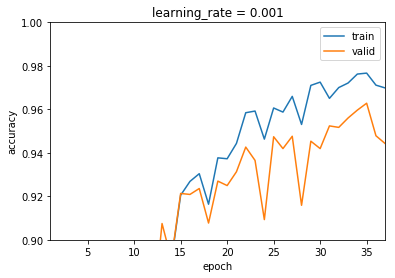

In [9]:
# Show the result on graph
plt.xlabel("epoch")
epoch = np.arange(1, accuracy_dict['train'].shape[0]+1, 1)
plt.ylabel("accuracy")
plt.axis([1,accuracy_dict['train'].shape[0], 0.9,1.0])
plt.title("learning_rate = "+str(learning_rate))

for data_type in ['train', 'valid'] :
    plt.plot(epoch,accuracy_dict[data_type], label=str(data_type))

plt.legend()
plt.show()

### Grayscale and Normalize the test data

In [ ]:
''' Grayscale the test data '''
print("Grayscaling...")
for i in range(n_test):
    X_test[i] = np.expand_dims(cv2.cvtColor(X_test[i], cv2.COLOR_RGB2GRAY), axis=3)
# Nx32x32x3 ---> Nx32x32x1
X_test = X_test[:, :, :, 0:1]
print("The test data has been grayscaled\n")


''' Normarize the test data '''
print("Normarizing...")
X_test = (X_test - np.mean(X_test)) / np.std(X_test)
print("The value data has been normarized\n")


''' Confirm the shape '''
print("The shape of  X_test is ", X_test.shape)
print("The shape of  y_test is ", y_test.shape)

In [ ]:
''' Test the model '''

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    Evaluate(X_test, y_test, 'test')

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import numpy as np
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline


''' Load new images from jpg file '''
n_images = 5
# Initialize `new_images` whose shape is same as `X_train` with zeros.
new_images = np.zeros([1, 32, 32, 3])
#new_images = np.zeros([1, X_train.shape[1], X_train.shape[2], 3])
for i in range(1, n_images+1):
    # Read an image
    image = mpimg.imread('./new_images/new_image'+str(i)+'.jpg')
    new_images = np.append(new_images, np.expand_dims(image,axis=0), axis=0)
# Trancate the first element of `new_images` that all elements are zeros, and cast to uint8 for RGB.
# (N+1)x32x32xC ---> Nx32x32xC
new_images = new_images[1: , ...].astype(np.uint8)
print("The shape of new_images is ", new_images.shape)


''' Load new labels from txt file '''
file_name = './new_images/new_labels.txt'
new_labels = np.array([])
with open(file_name) as f:
    for line in f.readlines():
        for label in line.split():
             new_labels = np.append(new_labels, int(label))
print("The shape of new_labels is ", new_labels.shape)
print("new_labels is ",new_labels)


''' Output the new images '''
fig, axes = plt.subplots(nrows=1, ncols=n_images)
for i in range(n_images):
    axes[i].imshow(new_images[i])
    axes[i].set_title("label = {}".format(int(new_labels[i])))
fig.subplots_adjust(right=2)
    
    
''' Save the new images & new labels data '''
new_images_file = './new_images.p'
new_labels_file = './new_labels.p'
with open(new_images_file, mode='wb') as f:
    pickle.dump(new_images, f)
with open(new_labels_file, mode='wb') as f:
    pickle.dump(new_labels, f)
print("The new_images & new_labels have been saved")

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

''' Load the new images & new labels data '''
print("Loading...")
new_images_file = './new_images.p'
new_labels_file = './new_labels.p'
with open(new_images_file, mode='rb') as f:
    new_images = pickle.load(f)
with open(new_labels_file, mode='rb') as f:
    new_labels = pickle.load(f)
print("The new_images & new_labels have been loaded")

print("The shape of loaded new_images is ", new_images.shape)
print("The shape of loaded new_labels is ", new_labels.shape)


''' Grayscale the test data '''
print("Grayscaling...")
for i in range(n_images):
    new_images[i] = np.expand_dims(cv2.cvtColor(new_images[i], cv2.COLOR_RGB2GRAY), axis=3)
# Nx32x32x3 ---> Nx32x32x1
new_images = new_images[:, :, :, 0:1]
print("The test data has been grayscaled\n")


''' Normarize the test data '''
print("Normarizing...")
new_images = (new_images - np.mean(new_images)) / np.std(new_images)
print("The value data has been normarized\n")


print("The shape of  new_images is ", new_images.shape)
print("The shape of  new_labels is ", new_labels.shape)
# Update the shape of a single image
image_shape = new_images[0].shape
print("Image data shape =", image_shape)

In [ ]:
''' Predict the Sign Type '''
print("new_labels is \n", new_labels.astype(int))

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    predict_logits, _, _ = CNN(X, W=Ws[best_epoch], b=bs[best_epoch])
    predict_logits = sess.run(predict_logits, feed_dict={X:new_images, y:new_labels})

    predicted_labels = sess.run(tf.argmax(predict_logits, 1))
    print("Result of prediction is \n", predicted_labels)
    
    softmax_logits = sess.run(tf.nn.softmax(predict_logits))
    top_k = 5
    top_predictions = sess.run(tf.nn.top_k(tf.constant(softmax_logits), k=top_k))
##ENDWITH`sess`


### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

print("Validation Accuracy by new images is ", np.mean(np.equal(predicted_labels, new_labels)))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

''' Load the images '''
print("Loading...")
train_file = './train.p'
augmented_y_train_file = './augmented_y_train.p'
new_images_file = './new_images.p'

with open(train_file, mode='rb') as f:
    train = pickle.load(f)
with open(augmented_y_train_file, mode='rb') as f:
    augmented_y_train = pickle.load(f)
with open(new_images_file, mode='rb') as f:
    new_images = pickle.load(f)

X_train, y_train= train['features'], train['labels']
print("\nThe original train images have been loaded")
print("Shape of original train images is ", X_train.shape)
print("\nThe train augmented labels have been loaded")
print("Shape of augmented labels is ", augmented_y_train.shape)
print("\nThe new_images have been loaded")
print("Shape of loaded new_images is ", new_images.shape)


''' Output the new images '''
print("\nnew_labels is \n", new_labels.astype(int))
print("Result of prediction is \n", predicted_labels)

fig, axes = plt.subplots(nrows=n_images, ncols=top_k+1)
for i in range(n_images):
    axes[i, 0].imshow(new_images[i])
    axes[i, 0].set_title("label = {}".format(int(new_labels[i])))
    for j in range(top_k):
        axes[i, j+1].imshow(X_train[np.argwhere(y_train==top_predictions[1][i][j])[0, 0]])
        axes[i, j+1].set_title("{} ({:.1f}%)".format(top_predictions[1][i][j], top_predictions[0][i][j]*100))
fig.subplots_adjust(right=2, top=3)


''' Count the number of images '''
n_labels = np.zeros(n_classes)
for i in range(n_classes):
    for j in range(augmented_y_train.shape[0]):
        if (augmented_y_train[j] == i):
            n_labels[i] += 1

# new_labels
plt.subplots(figsize=(15,5))
plt.xlabel('Black = new_labels')
plt.ylabel('number of images')
plt.title('Dataset distribution in augmented train data')
y_pos = np.arange(n_classes)
barlist = plt.bar(y_pos, n_labels, align='center', color='gray')
for i in range(n_images):
    barlist[int(new_labels[i])].set_color('k')
plt.xticks(y_pos, np.arange(n_classes))
plt.show()

# predicted_labels
plt.subplots(figsize=(15,5))
plt.xlabel('Purple = predicted_labels')
plt.ylabel('number of images')
plt.title('Dataset distribution in augmented train data')
y_pos = np.arange(n_classes)
barlist = plt.bar(y_pos, n_labels, align='center', color='gray')
for i in range(n_images):
    barlist[predicted_labels[i]].set_color('#624ea7')
plt.xticks(y_pos, np.arange(n_classes))
plt.show()

# corresponding labels
plt.subplots(figsize=(15,5))
plt.xlabel('Black = new_labels,\n Purple = predicted_labels,\n Red = corresponding labels')
plt.ylabel('number of images')
plt.title('Dataset distribution in augmented train data')
y_pos = np.arange(n_classes)
barlist = plt.bar(y_pos, n_labels, align='center', color='gray')
for i in range(n_images):
    barlist[int(new_labels[i])].set_color('k')
    barlist[predicted_labels[i]].set_color('#624ea7')
    if (new_labels[i] == predicted_labels[i]):
        barlist[predicted_labels[i]].set_color('r')
plt.xticks(y_pos, np.arange(n_classes))
plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")